In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

import sys,random

%load_ext autoreload
%autoreload 2

sys.path.append('..')
from util import provas,load_padr,score_inep, notas_sisu, params_inep


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
sns.set_theme(
    context='notebook',
    style='darkgrid',
    palette='deep',
    font='sans-serif',
    font_scale=1.3,
    color_codes=True,
    rc=None,
)
pd.options.display.float_format = '{:,.2f}'.format

In [76]:
ano = 2023
area = 'CH'
prova = random.choice(provas(ano,area))

padr, notas_inep = load_padr(prova,1000,nota_inep=True)
notas = score_inep(padr,prova,enemscale=True)
notas = notas.sort_values('nota')

Text(0, 0.5, 'Nota ENEM')

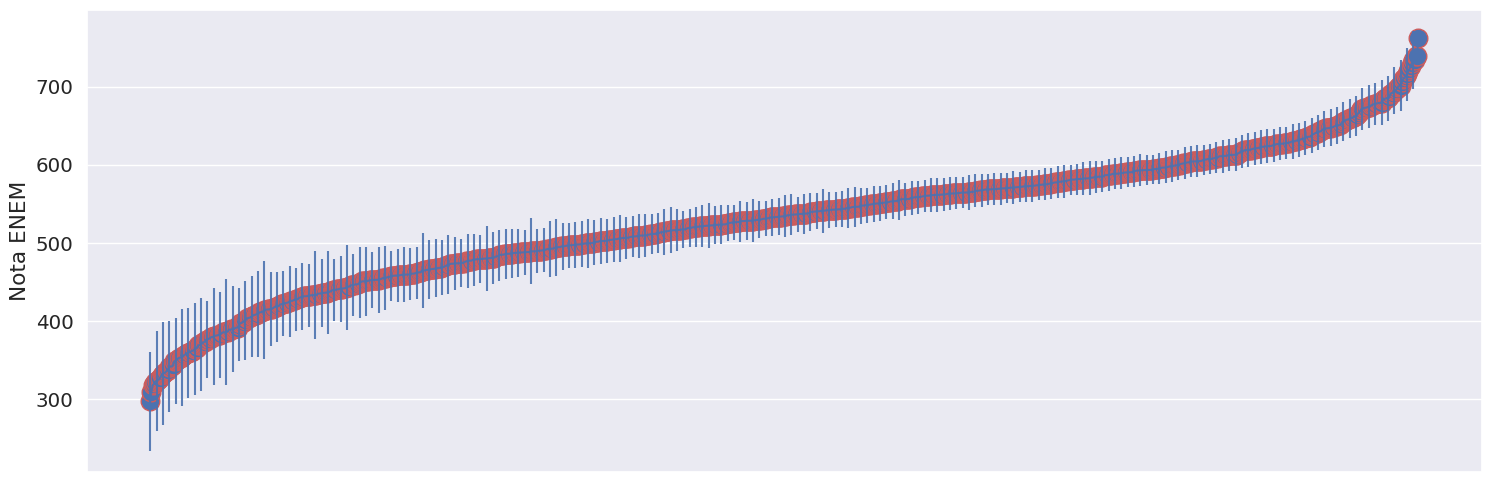

In [78]:
fig = plt.figure(figsize=(18,6))
x = list(range(1,len(notas)+1))
y = notas['nota']
se = notas['se']
plt.errorbar(x,y,yerr=se,fmt='',errorevery=5,alpha=0.9)
plt.scatter(x, y, s = 180,edgecolor = 'indianred')
ax = plt.gca()
ax.set_xticks([])
ax.set_ylabel("Nota ENEM")

In [92]:
divs = []
centers = []
div_corrente = 0
for i,(nota,se) in notas.iterrows():
    if nota-se > div_corrente:
        divs.append(nota-se)
        centers.append(nota)
        div_corrente = nota+se
divs.append(div_corrente)
divs = np.array(divs)
centers = np.array(centers)
divs 

array([233.71539651, 367.26046659, 450.14806133, 510.79809174,
       556.06316899, 595.31673217, 636.2405122 , 689.44054019,
       764.79872972])

In [95]:
errs = centers - divs[:-1]

In [55]:


def enemfig(ano,area):
    prova = random.choice(provas(ano,area))
    
    padr, notas_inep = load_padr(prova,1000,nota_inep=True)
    notas = score_inep(padr,prova,enemscale=True)
    notas = notas.sort_values('nota')    
    x = list(range(1,len(notas)+1))
    y = notas['nota']
    se = notas['se']
    fig = plt.figure(figsize=(9,6))
    plt.errorbar(x,y,yerr=se,fmt='',errorevery=5,alpha=0.9)
    plt.scatter(x, y, s = 180,edgecolor = 'indianred')
    ax = plt.gca()
    ax.set_xticks([])
    ax.set_ylim(200,1000)
    ax.set_ylabel("Nota ENEM")

interact(enemfig,ano=range(2009,2024),area=['CH','CN','MT']);

interactive(children=(Dropdown(description='ano', options=(2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 201…